**Import Library**

In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from itertools import product
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords



In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     |████████████████████████████████| 61kB 447kB/s eta 0:00:011
     |████████████████████████████████| 8.2MB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 4.7MB/s eta 0:00:01


In [ ]:
import pymorphy2

In [ ]:
sample_submissions=pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
sales_train_df=pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test_df=pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
items_df=pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops_df=pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
item_categories_df=pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")

We look at the data in the tables

In [ ]:
sample_submissions.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [ ]:
sales_train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
test_df.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


It can be seen from these tables that in the training set, shop_id changes from 0 to 59, and on the test set it changes from 2 to 59. Also, item_id on the training set changes from 0 to 22169, and on the test set from 30 to 22167. Therefore, these indices are not match. We’ll check this more carefully.

In [ ]:
print(sales_train_df["shop_id"].nunique())
print(test_df["shop_id"].nunique())

60
42


In [ ]:
print(sales_train_df["item_id"].nunique())
print(test_df["item_id"].nunique())

21807
5100


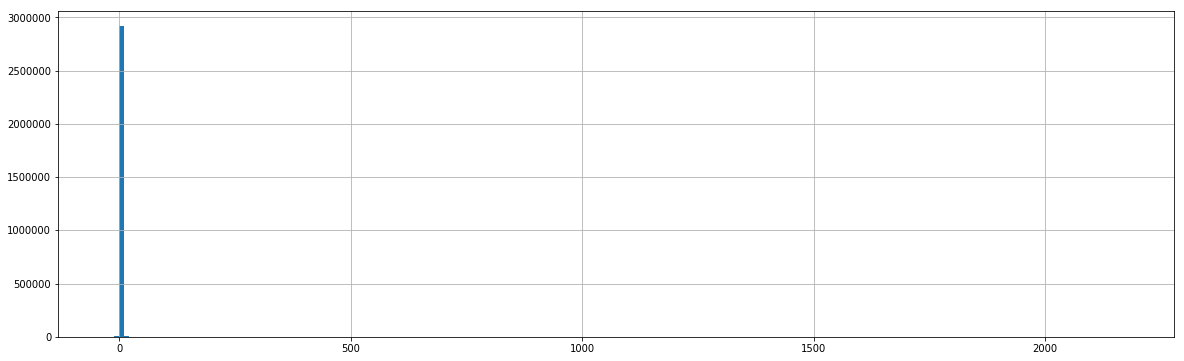

In [ ]:
plt.figure(figsize=(20,6))
sales_train_df["item_cnt_day"].hist(bins=200)

From this histogram we can see that most daily sales are in the range close to one.But on some items, sales are 2,000 or higher, and this may be an outlier.

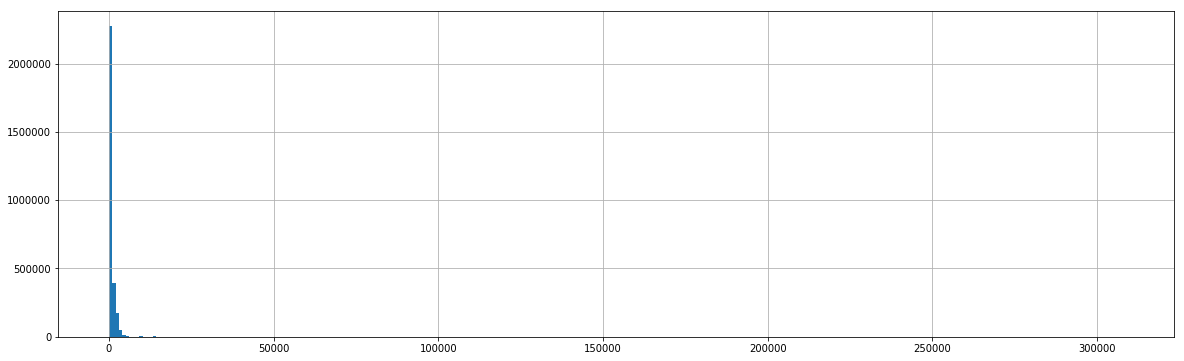

In [ ]:
plt.figure(figsize=(20,6))
sales_train_df["item_price"].hist(bins=300)

From this histogram we can see that most of the prices for items are in the range from 0 to about 1000. But there are also items with huge prices from 10000 to 300000. It can be outliers or just items with high price.

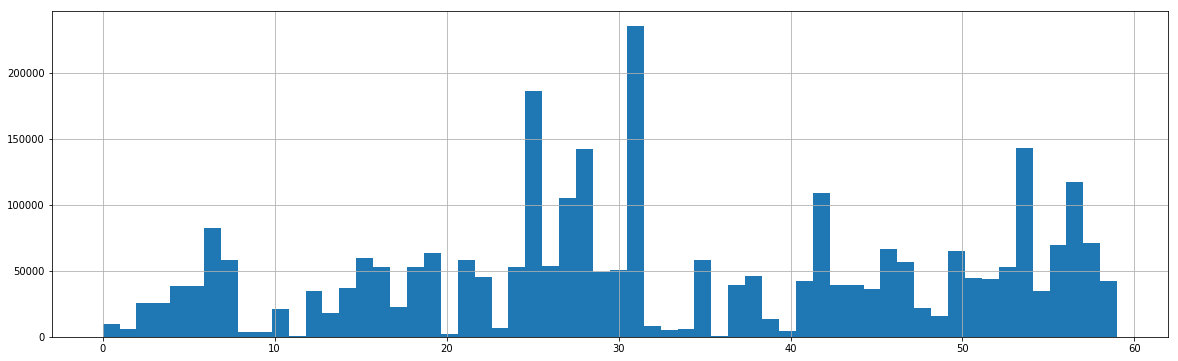

In [ ]:
plt.figure(figsize=(20,6))
sales_train_df["shop_id"].hist(bins=60)

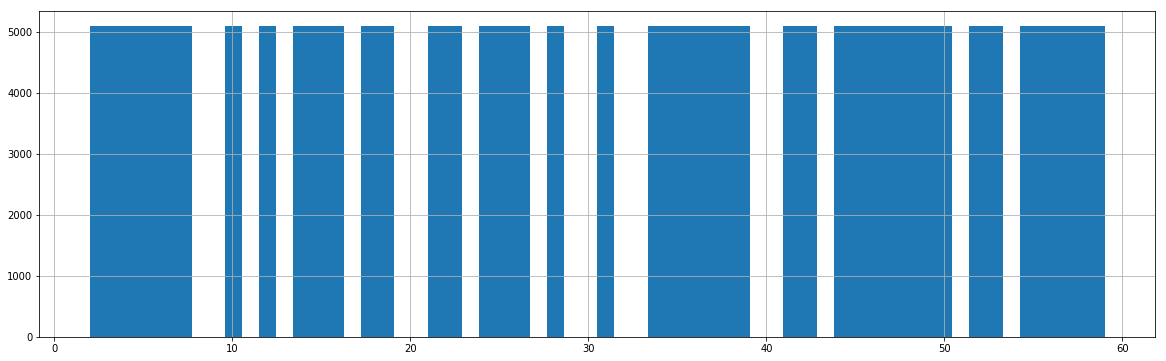

In [ ]:
plt.figure(figsize=(20,6))
test_df["shop_id"].hist(bins=60)

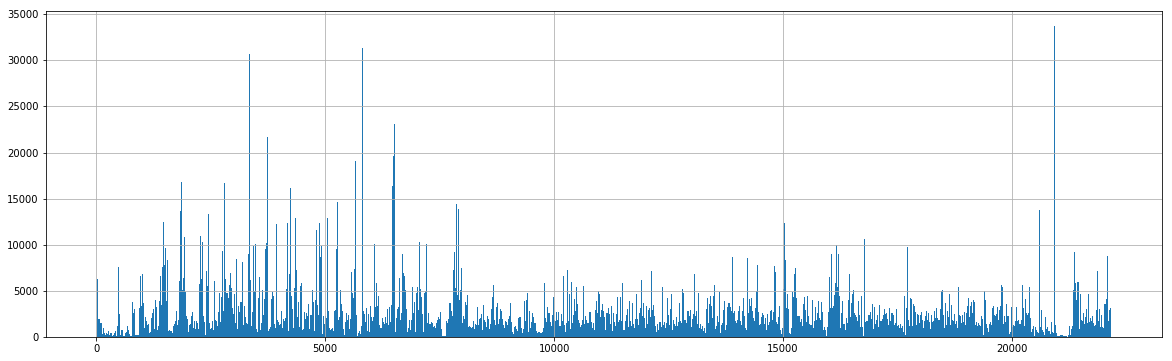

In [ ]:
plt.figure(figsize=(20,6))
sales_train_df["item_id"].hist(bins=1000)

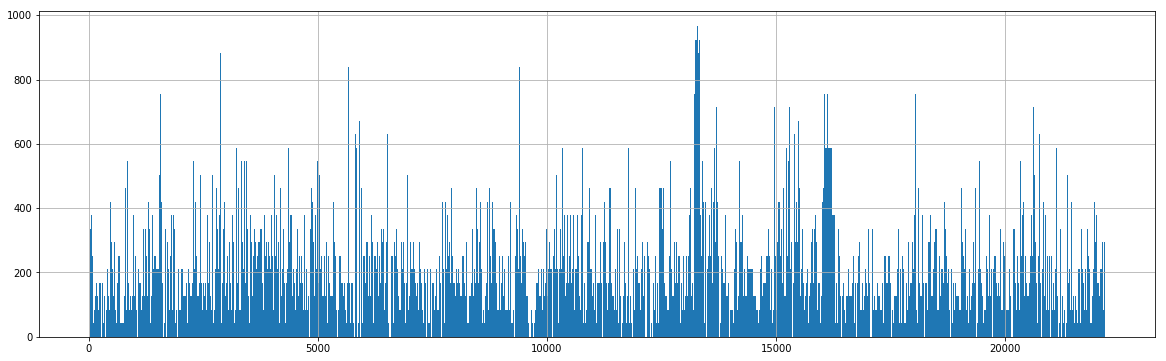

In [ ]:
plt.figure(figsize=(20,6))
test_df["item_id"].hist(bins=1000)

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def text_preprocessing(text):
  txt=""
  morph=pymorphy2.MorphAnalyzer()
  stop_words_ru=stopwords.words("russian")
  stop_words_eng=stopwords.words("english")
  stroka=re.sub('[^A-Za-zА-Яа-я]+',' ',text)
  strs=stroka.split(" ")
  filtered_strs=[morph.parse(w.lower())[0].normal_form for w in strs if (w not in stop_words_ru and w not in stop_words_eng)]
  txt=" ".join(filtered_strs)
  return txt

In [ ]:
'''%%time
items_df["item_name"]=items_df["item_name"].apply(lambda x:text_preprocessing(x))'''

'%%time\nitems_df["item_name"]=items_df["item_name"].apply(lambda x:text_preprocessing(x))'

In [ ]:
items_df["item_name"]

0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
1        !ABBYY FineReader 12 Professional Edition Full...
2            ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3          ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4              ***КОРОБКА (СТЕКЛО)                       D
                               ...                        
22165               Ядерный титбит 2 [PC, Цифровая версия]
22166      Язык запросов 1С:Предприятия  [Цифровая версия]
22167    Язык запросов 1С:Предприятия 8 (+CD). Хрустале...
22168                                  Яйцо для Little Inu
22169                        Яйцо дракона (Игра престолов)
Name: item_name, Length: 22170, dtype: object

In [ ]:
sales_train_df=sales_train_df.join(shops_df.set_index("shop_id"),on="shop_id",how="left").join(
items_df.set_index("item_id"),on="item_id",how="left").join(item_categories_df.set_index("item_category_id")
                                                              ,on="item_category_id",how="left")
sales_train_df.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999,899,899,1709.05,1099
item_cnt_day,1,1,-1,1,1
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [ ]:
test_df=test_df.join(shops_df.set_index("shop_id"),on="shop_id",how="left").join(
items_df.set_index("item_id"),on="item_id",how="left").join(item_categories_df.set_index("item_category_id")
                                                              ,on="item_category_id",how="left")
test_df.head().T

,0,1,2,3,4
ID,0,1,2,3,4
shop_id,5,5,5,5,5
item_id,5037,5320,5233,5232,5268
shop_name,"Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад""","Вологда ТРЦ ""Мармелад"""
item_name,"NHL 15 [PS3, русские субтитры]",ONE DIRECTION Made In The A.M.,"Need for Speed Rivals (Essentials) [PS3, русск...","Need for Speed Rivals (Classics) [Xbox 360, ру...","Need for Speed [PS4, русская версия]"
item_category_id,19,55,19,23,20
item_category_name,Игры - PS3,Музыка - CD локального производства,Игры - PS3,Игры - XBOX 360,Игры - PS4


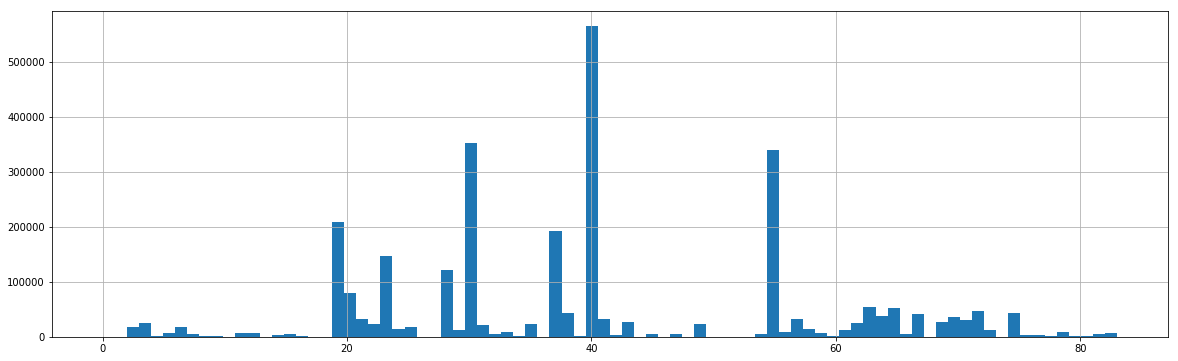

In [ ]:
plt.figure(figsize=(20,6))
sales_train_df["item_category_id"].hist(bins=84)

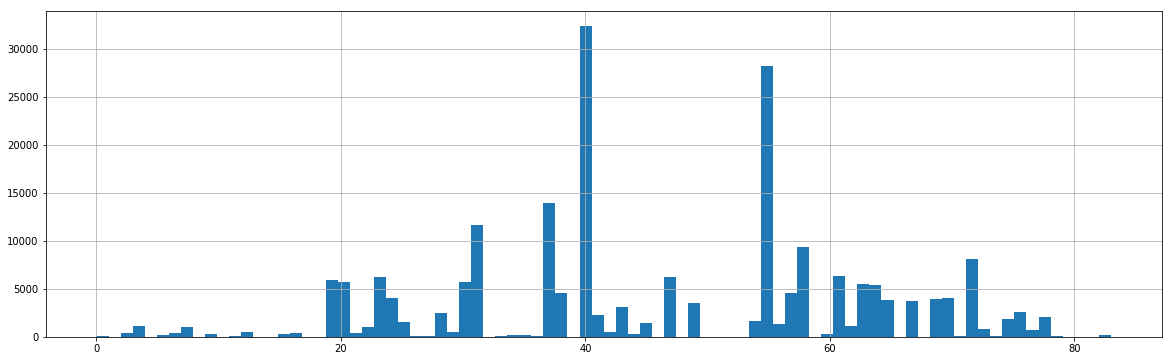

In [ ]:
plt.figure(figsize=(20,6))
test_df["item_category_id"].hist(bins=84)

The graphs show that to build a test set for each shop, we took all all the item-shop pairs that are present in the test dataset. You can build such a dataset from the training set by taking for each month all the unique item-shop pairs present in the test dataset.

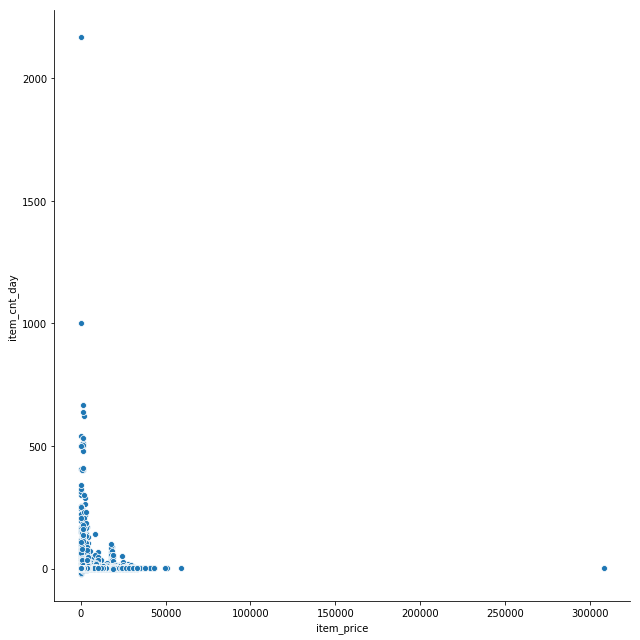

In [ ]:
sns.relplot(x="item_price",y="item_cnt_day",height=9,aspect=1,data=sales_train_df)

From this graph we see that in the dataset there are two points that can be outliers. One with sales over 2000. Another with a price of over 50000.

In [ ]:
sales_train_df[sales_train_df.item_cnt_day>2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2909818,28.10.2015,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара


In [ ]:
sales_train_df[sales_train_df.item_category_id==9]["item_cnt_day"].mean()

8.261741906064751

In [ ]:
sales_train_df[sales_train_df.item_id==11373]["item_cnt_day"].mean()

14.144396551724139

In [ ]:
sales_train_df[(sales_train_df.shop_id==12)&(sales_train_df.item_id==11373)]["item_cnt_day"].mean()

14.144396551724139

It seems that this point is really an outlier.

In [ ]:
sales_train_df=sales_train_df[~sales_train_df.isin(sales_train_df[sales_train_df.item_cnt_day>2000])]

In [ ]:
sales_train_df[sales_train_df.item_price>50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
885138,17.09.2013,8.0,12.0,11365.0,59200.0,1.0,Интернет-магазин ЧС,Доставка (EMS),9.0,Доставка товара
1163158,13.12.2013,11.0,12.0,6066.0,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75.0,Программы - Для дома и офиса
1488135,20.03.2014,14.0,25.0,13199.0,50999.0,1.0,"Москва ТРК ""Атриум""",Коллекционные шахматы (Властелин Колец),69.0,Подарки - Сувениры


In [ ]:
sales_train_df=sales_train_df[~sales_train_df.isin(sales_train_df[sales_train_df.item_price>50000])]

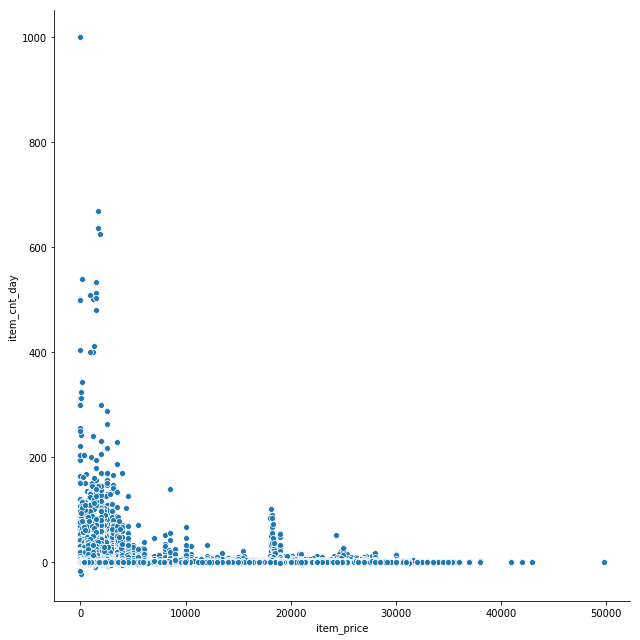

In [ ]:
sns.relplot(x="item_price",y="item_cnt_day",height=9,aspect=1,data=sales_train_df)

In [ ]:
sales_train_df[sales_train_df.item_cnt_day>800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2326930,15.01.2015,24.0,12.0,20949.0,4.0,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71.0,"Подарки - Сумки, Альбомы, Коврики д/мыши"


In [ ]:
sales_train_df[sales_train_df.item_id==20949]["item_cnt_day"].mean()

5.987300574345884

In [ ]:
sales_train_df[(sales_train_df.shop_id==12)&(sales_train_df.item_id==20949)]["item_cnt_day"].mean()

666.6666666666666

In [ ]:
sales_train_df=sales_train_df[~sales_train_df.isin(sales_train_df[sales_train_df.item_cnt_day>800])]

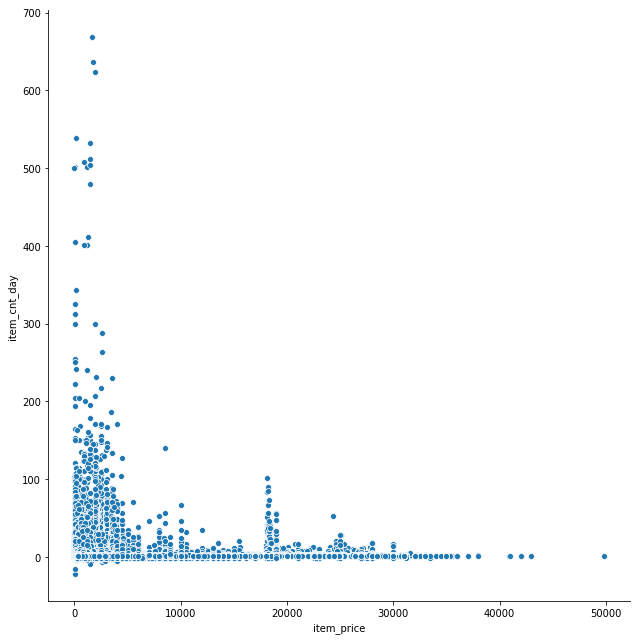

In [ ]:
sns.relplot(x="item_price",y="item_cnt_day",height=9,aspect=1,data=sales_train_df)

You can try to add pairs (item, shop) to each month and encode them using the median of sales for the category to which this item belongs in the corresponding month. To do this, join all the datasets with each other.

In [ ]:
item_id_uniq=pd.unique(sales_train_df["item_id"])

In [ ]:
test_unique_items=test_df[~test_df["item_id"].isin(item_id_uniq)]
test_unique_items.head()

,ID,shop_id,item_id,shop_name,item_name,item_category_id,item_category_name
1,1,5,5320,"Вологда ТРЦ ""Мармелад""",ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства
4,4,5,5268,"Вологда ТРЦ ""Мармелад""","Need for Speed [PS4, русская версия]",20,Игры - PS4
45,45,5,5826,"Вологда ТРЦ ""Мармелад""",Pokemon XY Грохочущие Небеса Блистер,65,Подарки - Настольные игры (компактные)
64,64,5,3538,"Вологда ТРЦ ""Мармелад""","Football Manager 2016 [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания
65,65,5,3571,"Вологда ТРЦ ""Мармелад""",GAHAN DAVE & SOULSAVERS Angels & Ghosts,55,Музыка - CD локального производства


In [ ]:
test_unique_items.shape

(15246, 7)

In [ ]:
test_unique_items["item_id"].nunique()

363

In [ ]:
sales_train_df.shape

(2935849, 10)

In [ ]:
%%time
train=[]
col=["date_block_num","shop_id","item_id"]
for i in range(34):
  sales=sales_train_df[sales_train_df.date_block_num==i]
  train.append(np.array(list(product([i],sales.shop_id.unique(),sales.item_id.unique())),dtype="int16"))
train=pd.DataFrame(np.vstack(train),columns=col)
train["date_block_num"]=train["date_block_num"].astype(np.int8)
train["shop_id"]=train["shop_id"].astype(np.int8)
train["item_id"]=train["item_id"].astype(np.int16)
print(train.head())

   date_block_num  shop_id  item_id
0               0       59    22154
1               0       59     2552
2               0       59     2554
3               0       59     2555
4               0       59     2564
CPU times: user 17.7 s, sys: 449 ms, total: 18.1 s
Wall time: 18.1 s


In [ ]:
month_df=sales_train_df[["date_block_num","shop_id","item_id","item_cnt_day"]].groupby(["date_block_num","shop_id","item_id"]).sum()
month_df.head()

item_cnt_day
date_block_num shop_id item_id              
0.0            0.0     32.0              6.0
                       33.0              3.0
                       35.0              1.0
                       43.0              1.0
                       51.0              2.0

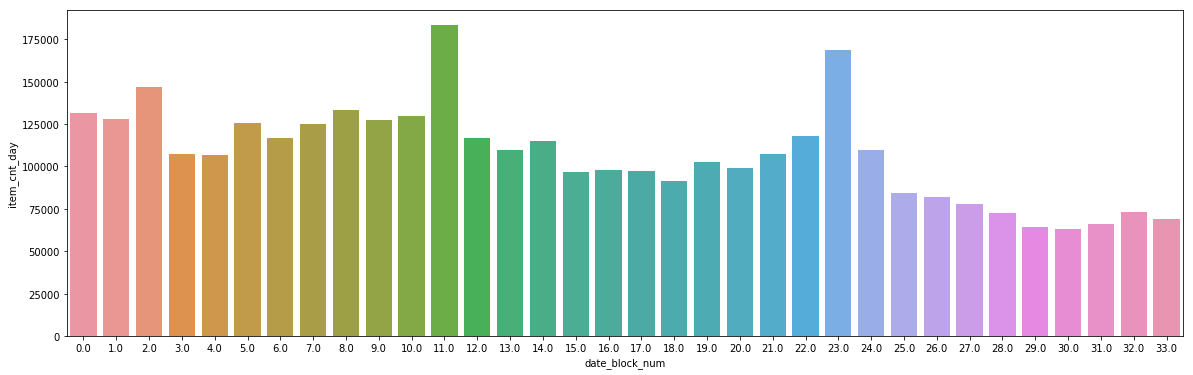

In [ ]:
date_block_total=month_df.reset_index()
date_block_total_group=date_block_total[["date_block_num","item_cnt_day"]].groupby("date_block_num",as_index=False).sum()
plt.figure(figsize=(20,6))
sns.barplot(x="date_block_num",y="item_cnt_day",data=date_block_total_group)

In [ ]:
date_block_total["year"]=date_block_total.date_block_num.apply(lambda x:((x//12)+2013))
date_block_total["month"]=date_block_total.date_block_num.apply(lambda x: (x%12))
date_block_total.head()

,date_block_num,shop_id,item_id,item_cnt_day,year,month
0,0.0,0.0,32.0,6.0,2013.0,0.0
1,0.0,0.0,33.0,3.0,2013.0,0.0
2,0.0,0.0,35.0,1.0,2013.0,0.0
3,0.0,0.0,43.0,1.0,2013.0,0.0
4,0.0,0.0,51.0,2.0,2013.0,0.0


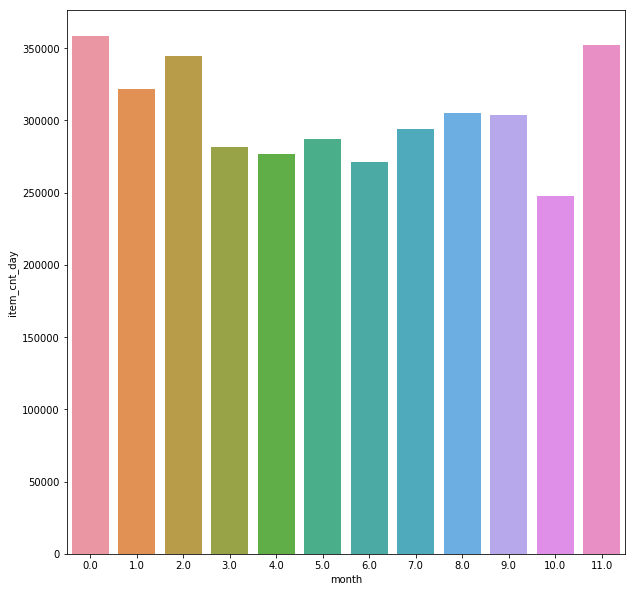

In [ ]:
total_month=date_block_total[["month","item_cnt_day"]].groupby("month",as_index=False).sum()
plt.figure(figsize=(10,10))
sns.barplot(x="month",y="item_cnt_day",data=total_month)

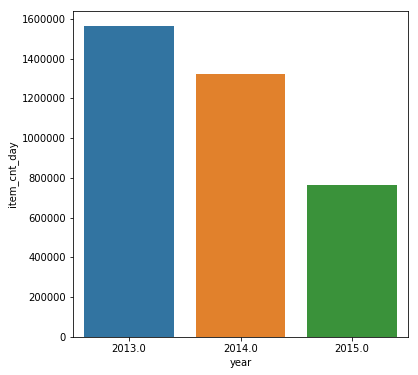

In [ ]:
total_year=date_block_total[["year","item_cnt_day"]].groupby("year",as_index=False).sum()
plt.figure(figsize=(6,6))
sns.barplot(x="year",y="item_cnt_day",data=total_year)

From this graph, an upward seasonal trend is visible from the first months of the year to the last. And the downward seasonal trend of sales by years from 2013 to 2015.

In [ ]:
train["year"]=train.date_block_num.apply(lambda x:((x//12)+2013))
train["month"]=train.date_block_num.apply(lambda x: (x%12))
train["year"]=train["year"].astype(np.int16)
train["month"]=train["month"].astype(np.int8)
train.head()

,date_block_num,shop_id,item_id,year,month
0,0,59,22154,2013,0
1,0,59,2552,2013,0
2,0,59,2554,2013,0
3,0,59,2555,2013,0
4,0,59,2564,2013,0


In [ ]:
test_df=pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
test_df["date_block_num"]=34
test_df["year"]=((34//12)+2013)
test_df["month"]=(34%12)
test_df["date_block_num"]=test_df["date_block_num"].astype(np.int8)
test_df["shop_id"]=test_df["shop_id"].astype(np.int8)
test_df["item_id"]=test_df["item_id"].astype(np.int16)
test_df["year"]=test_df["year"].astype(np.int16)
test_df["month"]=test_df["month"].astype(np.int8)
test_df.head()

,ID,shop_id,item_id,date_block_num,year,month
0,0,5,5037,34,2015,10
1,1,5,5320,34,2015,10
2,2,5,5233,34,2015,10
3,3,5,5232,34,2015,10
4,4,5,5268,34,2015,10


In [ ]:
categorical=["year","month"]

Create Target Variable

In [ ]:
train=train.join(month_df,on=["date_block_num","shop_id","item_id"],how="left")
train["item_cnt_day"]=train["item_cnt_day"].fillna(0).clip(0,20).astype(np.float16)
train.head()

,date_block_num,shop_id,item_id,year,month,item_cnt_day
0,0,59,22154,2013,0,1.0
1,0,59,2552,2013,0,0.0
2,0,59,2554,2013,0,0.0
3,0,59,2555,2013,0,0.0
4,0,59,2564,2013,0,0.0


In [ ]:
train=pd.concat([train,test_df],ignore_index=True,sort=False,keys=col)
train.fillna(0,inplace=True)
train.head()

,date_block_num,shop_id,item_id,year,month,item_cnt_day,ID
0,0,59,22154,2013,0,1.0,0.0
1,0,59,2552,2013,0,0.0,0.0
2,0,59,2554,2013,0,0.0,0.0
3,0,59,2555,2013,0,0.0,0.0
4,0,59,2564,2013,0,0.0,0.0


Create Lag Features For Total Month Cnt

In [ ]:
def create_lag_features(df,feature):
  numeric_features=[]
  for i in range(1,7):
    lagged=df.copy()
    lagged=lagged[["date_block_num","shop_id","item_id",feature]]
    lagged.columns=["date_block_num","shop_id","item_id",feature+"_lag_"+str(i)]
    numeric_features.append(feature+"_lag_"+str(i))
    lagged["date_block_num"]+=i
    df=df.join(lagged.set_index(["date_block_num","shop_id","item_id"]),on=["date_block_num","shop_id","item_id"],how="left")
  return df,numeric_features

In [ ]:
%%time
train,n_col=create_lag_features(train,"item_cnt_day")
train=train.fillna(0)
numeric=n_col

CPU times: user 41.1 s, sys: 11.6 s, total: 52.7 s
Wall time: 52.7 s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34.0,34.0,34.0,34.0,34.0
shop_id,45.0,45.0,45.0,45.0,45.0
item_id,18454.0,16188.0,15757.0,19648.0,969.0
year,2015.0,2015.0,2015.0,2015.0,2015.0
month,10.0,10.0,10.0,10.0,10.0
item_cnt_day,0.0,0.0,0.0,0.0,0.0
ID,214195.0,214196.0,214197.0,214198.0,214199.0
item_cnt_day_lag_1,1.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_2,0.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_3,0.0,0.0,0.0,0.0,0.0


Create Lag Features For Item Id Total Cnt

In [ ]:
total_cnt_for_items=sales_train_df[["date_block_num","item_id","item_cnt_day"]].groupby(["date_block_num","item_id"]).sum()
total_cnt_for_items.columns=["total_cnt_for_items"]
total_cnt_for_items.head()

total_cnt_for_items
date_block_num item_id                     
0.0            19.0                     1.0
               27.0                     7.0
               28.0                     8.0
               29.0                     4.0
               32.0                   299.0

In [ ]:
train=train.join(total_cnt_for_items,on=["date_block_num","item_id"],how="left")
train.fillna(0,inplace=True)
train["total_cnt_for_items"]=train["total_cnt_for_items"].astype(np.float16)
train.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,59.0,59.0,59.0,59.0,59.0
item_id,22154.0,2552.0,2554.0,2555.0,2564.0
year,2013.0,2013.0,2013.0,2013.0,2013.0
month,0.0,0.0,0.0,0.0,0.0
item_cnt_day,1.0,0.0,0.0,0.0,0.0
ID,0.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_1,0.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_2,0.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_3,0.0,0.0,0.0,0.0,0.0


In [ ]:
%%time
train,n_col=create_lag_features(train,"total_cnt_for_items")
train=train.fillna(0)
train=train.drop(["total_cnt_for_items"],axis=1)
numeric=numeric+n_col

CPU times: user 43.1 s, sys: 12.6 s, total: 55.7 s
Wall time: 55.7 s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34.0,34.0,34.0,34.0,34.0
shop_id,45.0,45.0,45.0,45.0,45.0
item_id,18454.0,16188.0,15757.0,19648.0,969.0
year,2015.0,2015.0,2015.0,2015.0,2015.0
month,10.0,10.0,10.0,10.0,10.0
item_cnt_day,0.0,0.0,0.0,0.0,0.0
ID,214195.0,214196.0,214197.0,214198.0,214199.0
item_cnt_day_lag_1,1.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_2,0.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_3,0.0,0.0,0.0,0.0,0.0


Create Features For shop_id.

In [ ]:
total_cnt_for_shops=sales_train_df[["date_block_num","shop_id","item_cnt_day"]].groupby(["date_block_num","shop_id"]).sum()
total_cnt_for_shops.columns=["total_cnt_for_shops"]
total_cnt_for_shops.head()

total_cnt_for_shops
date_block_num shop_id                     
0.0            0.0                   5578.0
               1.0                   2947.0
               2.0                   1146.0
               3.0                    767.0
               4.0                   2114.0

In [ ]:
sum_cnt_shops=total_cnt_for_shops.reset_index()
cnt_shops=sum_cnt_shops[["shop_id","total_cnt_for_shops"]].groupby("shop_id",as_index=False).mean()
cnt_shops=cnt_shops.join(shops_df.set_index(["shop_id"]),on="shop_id",how="left")
cnt_shops.head()

,shop_id,total_cnt_for_shops,shop_name
0,0.0,5852.500000,"!Якутск Орджоникидзе, 56 фран"
1,1.0,3155.500000,"!Якутск ТЦ ""Центральный"" фран"
2,2.0,900.588235,"Адыгея ТЦ ""Мега"""
3,3.0,833.970588,"Балашиха ТРК ""Октябрь-Киномир"""
4,4.0,1292.411765,"Волжский ТЦ ""Волга Молл"""


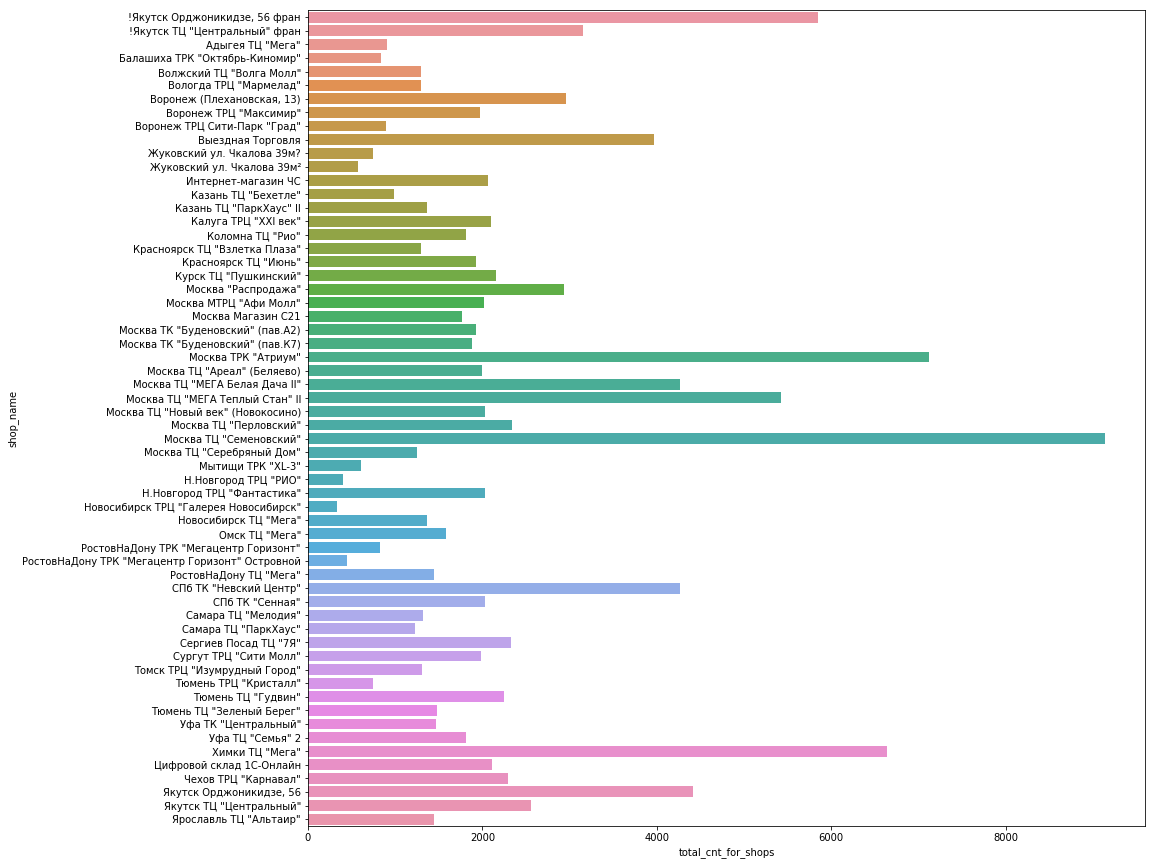

In [ ]:
plt.figure(figsize=(15,15))
sns.barplot(x="total_cnt_for_shops",y="shop_name",orient="h",data=cnt_shops)

In [ ]:
cnt_shops.loc[cnt_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
cnt_shops['shop_city'] = cnt_shops['shop_name'].str.split(' ').map(lambda x: x[0])
cnt_shops.loc[cnt_shops.shop_city == '!Якутск', 'shop_city'] = 'Якутск'
cnt_shops['shop_type'] = cnt_shops['shop_name'].str.split(' ').map(lambda x: x[1])
cnt_shops.head()

,shop_id,total_cnt_for_shops,shop_name,shop_city,shop_type
0,0.0,5852.500000,"!Якутск Орджоникидзе, 56 фран",Якутск,"Орджоникидзе,"
1,1.0,3155.500000,"!Якутск ТЦ ""Центральный"" фран",Якутск,ТЦ
2,2.0,900.588235,"Адыгея ТЦ ""Мега""",Адыгея,ТЦ
3,3.0,833.970588,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,ТРК
4,4.0,1292.411765,"Волжский ТЦ ""Волга Молл""",Волжский,ТЦ


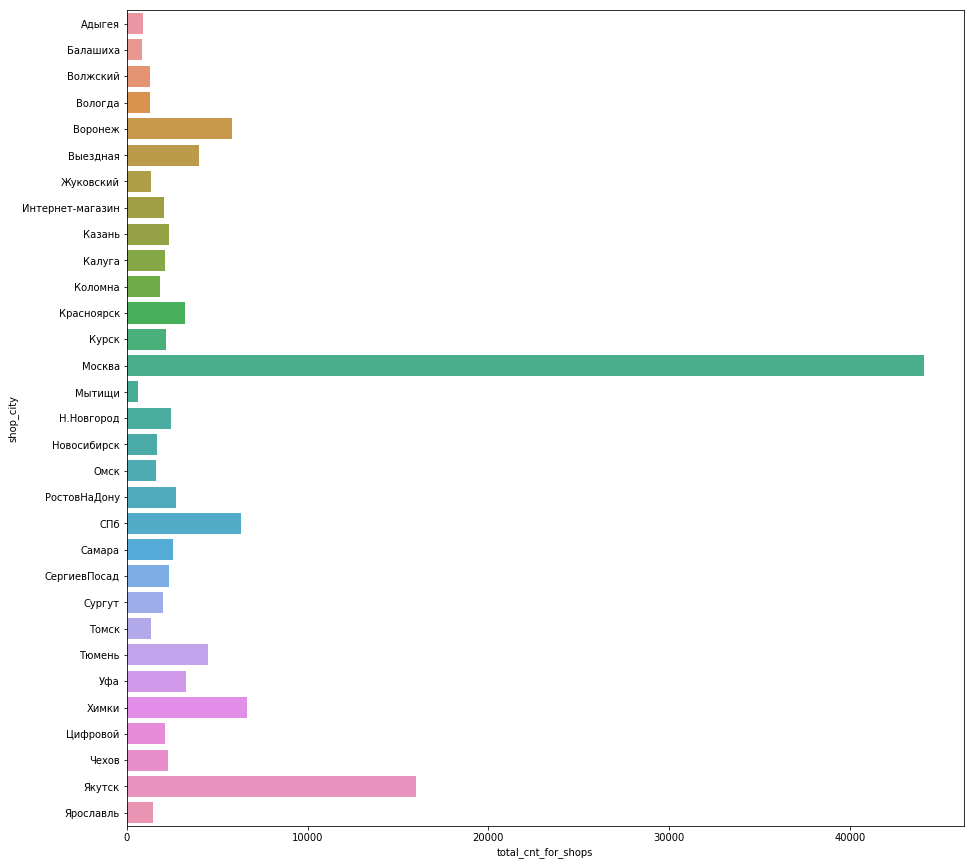

In [ ]:
sum_cnt_shop_city=cnt_shops[["shop_city","total_cnt_for_shops"]].groupby("shop_city",as_index=False).sum()
plt.figure(figsize=(15,15))
sns.barplot(x="total_cnt_for_shops",y="shop_city",orient="h",data=sum_cnt_shop_city)

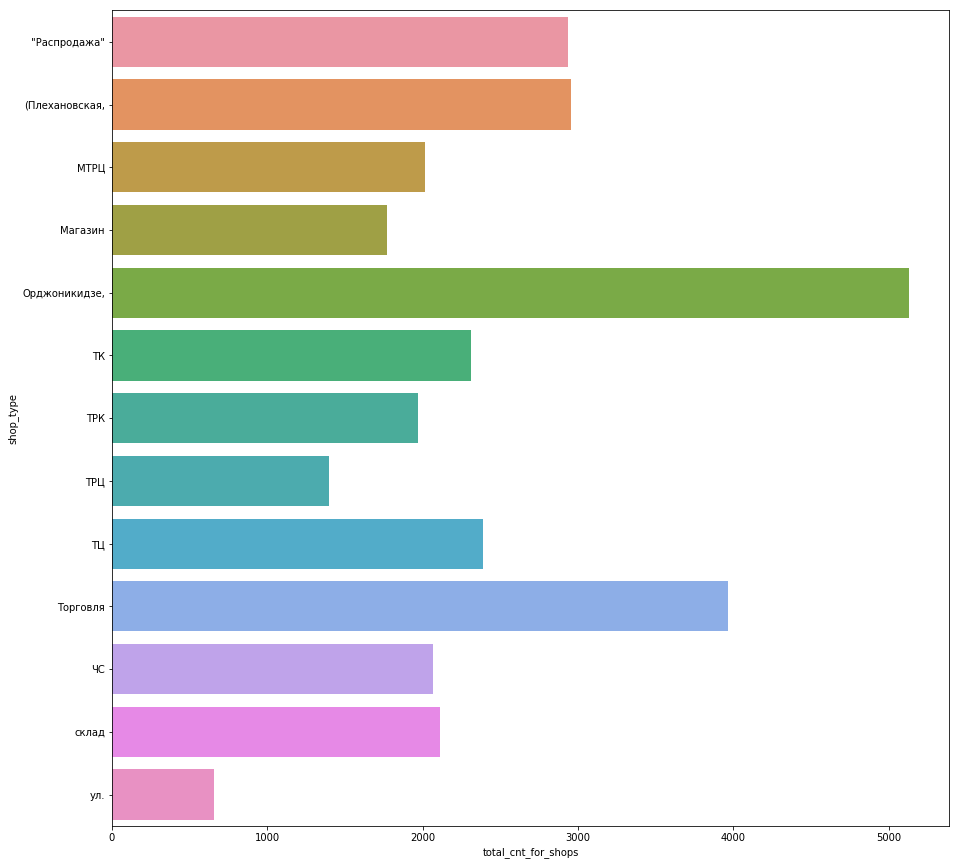

In [ ]:
sum_cnt_shop_type=cnt_shops[["shop_type","total_cnt_for_shops"]].groupby("shop_type",as_index=False).mean()
plt.figure(figsize=(15,15))
sns.barplot(x="total_cnt_for_shops",y="shop_type",orient="h",data=sum_cnt_shop_type)

In [ ]:
train=train.join(cnt_shops[["shop_id","shop_city","shop_type"]].set_index(["shop_id"]),on="shop_id",how="left")
train.fillna(0,inplace=True)
train["shop_city"]=train["shop_city"].astype(str)
train["shop_type"]=train["shop_type"].astype(str)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
categorical=categorical+["shop_city","shop_type"]

Create Lag Features For shop_id.

In [ ]:
train=train.join(total_cnt_for_shops,on=["date_block_num","shop_id"],how="left")
train.fillna(0,inplace=True)
train["total_cnt_for_shops"]=train["total_cnt_for_shops"].astype(np.float16)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
%%time
train,n_col=create_lag_features(train,"total_cnt_for_shops")
train=train.fillna(0)
train=train.drop(["total_cnt_for_shops"],axis=1)
numeric=numeric+n_col

CPU times: user 48.6 s, sys: 16.1 s, total: 1min 4s
Wall time: 1min 4s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
item_cnt_day,0,0,0,0,0
ID,214195,214196,214197,214198,214199
item_cnt_day_lag_1,1,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


Create Features For item_category_id.

In [ ]:
total_cnt_for_item_categories=sales_train_df[["date_block_num","item_category_id","item_cnt_day"]].groupby(["date_block_num","item_category_id"]).sum()
total_cnt_for_item_categories.columns=["total_cnt_for_item_categories"]
total_cnt_for_item_categories.head()

total_cnt_for_item_categories
date_block_num item_category_id                               
0.0            0.0                                         1.0
               1.0                                         1.0
               2.0                                      1390.0
               3.0                                       440.0
               4.0                                       251.0

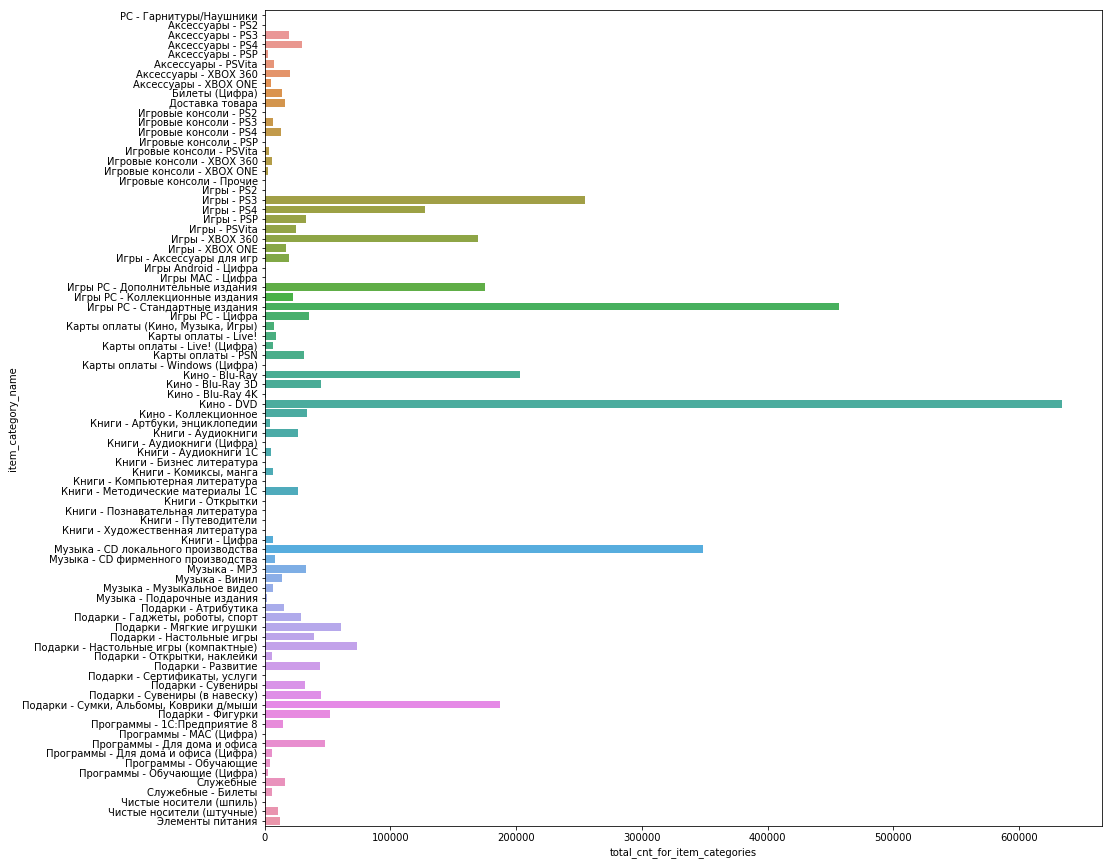

In [ ]:
sum_cnt_for_item_category=total_cnt_for_item_categories.reset_index()
sum_cnt_for_item_category=sum_cnt_for_item_category[["item_category_id","total_cnt_for_item_categories"]].groupby("item_category_id",as_index=False).sum()
sum_cnt_for_item_category=sum_cnt_for_item_category.join(item_categories_df.set_index("item_category_id"),on=["item_category_id"],how="left")
plt.figure(figsize=(15,15))
sns.barplot(x="total_cnt_for_item_categories",y="item_category_name",orient="h",data=sum_cnt_for_item_category)

Two variable categories and a sibcategory can be extracted from the category name.

In [ ]:
sum_cnt_for_item_category["category"]=sum_cnt_for_item_category.item_category_name.str.split("-").str[0]
sum_cnt_for_item_category["subcategory"]=sum_cnt_for_item_category.item_category_name.str.split("-").str[1]
sum_cnt_for_item_category.head()

,item_category_id,total_cnt_for_item_categories,item_category_name,category,subcategory
0,0.0,3.0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники
1,1.0,2.0,Аксессуары - PS2,Аксессуары,PS2
2,2.0,19597.0,Аксессуары - PS3,Аксессуары,PS3
3,3.0,29807.0,Аксессуары - PS4,Аксессуары,PS4
4,4.0,2407.0,Аксессуары - PSP,Аксессуары,PSP


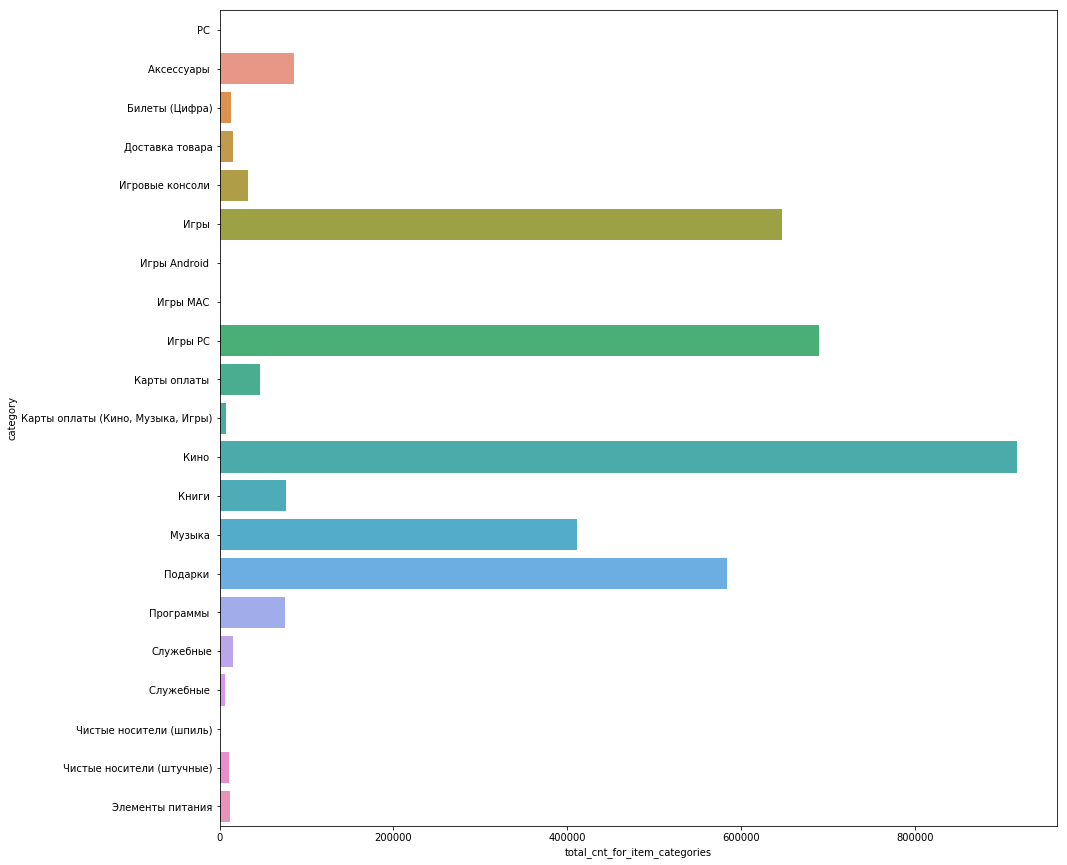

In [ ]:
sum_cnt_category=sum_cnt_for_item_category[["category","total_cnt_for_item_categories"]].groupby("category",as_index=False).sum()
plt.figure(figsize=(15,15))
sns.barplot(x="total_cnt_for_item_categories",y="category",orient="h",data=sum_cnt_category)

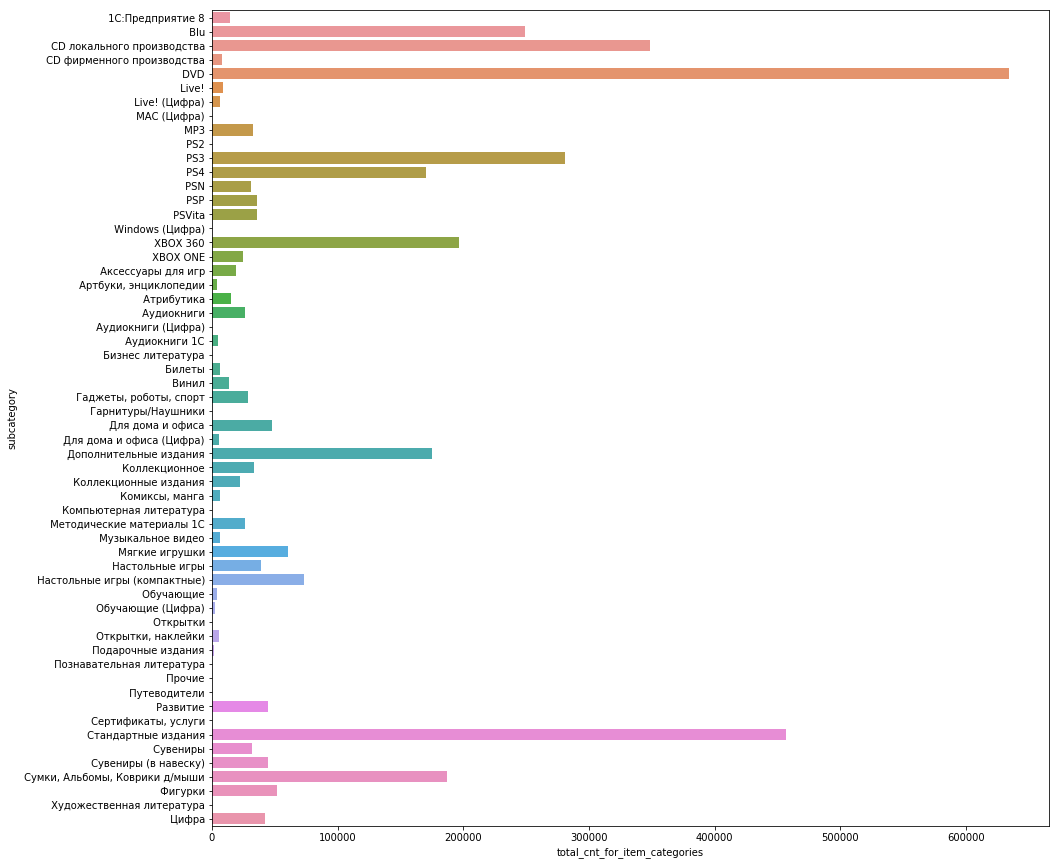

In [ ]:
sum_cnt_subcategory=sum_cnt_for_item_category[["subcategory","total_cnt_for_item_categories"]].groupby("subcategory",as_index=False).sum()
plt.figure(figsize=(15,15))
sns.barplot(x="total_cnt_for_item_categories",y="subcategory",orient="h",data=sum_cnt_subcategory)

In [ ]:
train=train.join(items_df.set_index(["item_id"]),on=["item_id"],how="left")
train=train.join(sum_cnt_for_item_category[["item_category_id","category","subcategory"]].set_index(["item_category_id"]),on=["item_category_id"],how="left")
train.fillna(0,inplace=True)
train["category"]=train["category"].astype(str)
train["subcategory"]=train["subcategory"].astype(str)
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
item_cnt_day,0,0,0,0,0
ID,214195,214196,214197,214198,214199
item_cnt_day_lag_1,1,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
categorical=categorical+["category","subcategory"]

In [ ]:
train=train.join(total_cnt_for_item_categories,on=["date_block_num","item_category_id"],how="left")
train.fillna(0,inplace=True)
train["total_cnt_for_item_categories"]=train["total_cnt_for_item_categories"].astype(np.float16)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
%%time
train,n_col=create_lag_features(train,"total_cnt_for_item_categories")
train=train.fillna(0)
train=train.drop(["total_cnt_for_item_categories"],axis=1)
numeric=numeric+n_col

CPU times: user 1min 8s, sys: 25.5 s, total: 1min 33s
Wall time: 1min 33s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
item_cnt_day,0,0,0,0,0
ID,214195,214196,214197,214198,214199
item_cnt_day_lag_1,1,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
train["item_name"]

0                                           ЯВЛЕНИЕ 2012 (BD)
1                    DEEP PURPLE  The House Of Blue Light  LP
2                    DEEP PURPLE  Who Do You Think We Are  LP
3                     DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
4           DEEP PURPLE Perihelion: Live In Concert DVD (К...
                                  ...                        
11127951                                          СБ. Союз 55
11127952                         Настольная игра Нано Кёрлинг
11127953                   НОВИКОВ АЛЕКСАНДР  Новая коллекция
11127954                      ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион)
11127955                               3 ДНЯ НА УБИЙСТВО (BD)
Name: item_name, Length: 11127956, dtype: object

Create Features For item_price

In [ ]:
mean_price=sales_train_df[["date_block_num","shop_id","item_id","item_price"]].groupby(["date_block_num","shop_id","item_id"]).mean()
mean_price.columns=["mean_price"]
mean_price.head()

mean_price
date_block_num shop_id item_id            
0.0            0.0     32.0          221.0
                       33.0          347.0
                       35.0          247.0
                       43.0          221.0
                       51.0          128.5

In [ ]:
train=train.join(mean_price,on=["date_block_num","shop_id","item_id"],how="left")
train.fillna(0,inplace=True)
train["mean_price"]=train["mean_price"].astype(np.float16)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
%%time
train,n_col=create_lag_features(train,"mean_price")
train=train.fillna(0)
train=train.drop(["mean_price"],axis=1)
numeric=numeric+n_col

CPU times: user 1min 10s, sys: 31.9 s, total: 1min 42s
Wall time: 1min 42s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
item_cnt_day,0,0,0,0,0
ID,214195,214196,214197,214198,214199
item_cnt_day_lag_1,1,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
mean_price_for_items=sales_train_df[["date_block_num","item_id","item_price"]].groupby(["date_block_num","item_id"]).mean()
mean_price_for_items.columns=["mean_price_for_items"]
mean_price_for_items.head()

mean_price_for_items
date_block_num item_id                      
0.0            19.0                28.000000
               27.0              2325.000000
               28.0               549.000000
               29.0              2397.500000
               32.0               338.110349

In [ ]:
train=train.join(mean_price_for_items,on=["date_block_num","item_id"],how="left")
train.fillna(0,inplace=True)
train["mean_price_for_items"]=train["mean_price_for_items"].astype(np.float16)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
%%time
train,n_col=create_lag_features(train,"mean_price_for_items")
train=train.fillna(0)
train=train.drop(["mean_price_for_items"],axis=1)
numeric=numeric+n_col

CPU times: user 1min 13s, sys: 28 s, total: 1min 41s
Wall time: 1min 41s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
item_cnt_day,0,0,0,0,0
ID,214195,214196,214197,214198,214199
item_cnt_day_lag_1,1,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
mean_price_for_item_categories=sales_train_df[["date_block_num","item_category_id","item_price"]].groupby(["date_block_num","item_category_id"]).mean()
mean_price_for_item_categories.columns=["mean_price_for_item_categories"]
mean_price_for_item_categories.head()

mean_price_for_item_categories
date_block_num item_category_id                                
0.0            0.0                                   148.000000
               1.0                                   148.000000
               2.0                                  2107.245400
               3.0                                   477.099212
               4.0                                   921.920168

In [ ]:
train=train.join(mean_price_for_item_categories,on=["date_block_num","item_category_id"],how="left")
train.fillna(0,inplace=True)
train["mean_price_for_item_categories"]=train["mean_price_for_item_categories"].astype(np.float16)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
%%time
train,n_col=create_lag_features(train,"mean_price_for_item_categories")
train=train.fillna(0)
train=train.drop(["mean_price_for_item_categories"],axis=1)
numeric=numeric+n_col

CPU times: user 1min 14s, sys: 28.9 s, total: 1min 43s
Wall time: 1min 43s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
item_cnt_day,0,0,0,0,0
ID,214195,214196,214197,214198,214199
item_cnt_day_lag_1,1,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
sales_train_df["revenue"]=sales_train_df["item_price"]*sales_train_df["item_cnt_day"]
total_revenue=sales_train_df[["date_block_num","shop_id","revenue"]].groupby(["date_block_num","shop_id"]).sum()
total_revenue.columns=["total_shop_revenue"]
total_revenue.head()

total_shop_revenue
date_block_num shop_id                    
0.0            0.0              2966412.00
               1.0              1527320.00
               2.0              1085064.80
               3.0               560585.01
               4.0              1433666.00

In [ ]:
train=train.join(total_revenue,on=["date_block_num","shop_id"],how="left")
train["total_shop_revenue"]=train["total_shop_revenue"].astype(np.float32)
train.fillna(0,inplace=True)
train.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,59,59,59,59,59
item_id,22154,2552,2554,2555,2564
year,2013,2013,2013,2013,2013
month,0,0,0,0,0
item_cnt_day,1,0,0,0,0
ID,0,0,0,0,0
item_cnt_day_lag_1,0,0,0,0,0
item_cnt_day_lag_2,0,0,0,0,0
item_cnt_day_lag_3,0,0,0,0,0


In [ ]:
%%time
train,n_col=create_lag_features(train,"total_shop_revenue")
train=train.fillna(0.0)
train=train.drop(["total_shop_revenue"],axis=1)
numeric=numeric+n_col

CPU times: user 1min 15s, sys: 30 s, total: 1min 45s
Wall time: 1min 45s


In [ ]:
train.tail().T

,11127951,11127952,11127953,11127954,11127955
date_block_num,34,34,34,34,34
shop_id,45,45,45,45,45
item_id,18454,16188,15757,19648,969
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
...,...,...,...,...,...
total_shop_revenue_lag_2,866123,866123,866123,866123,866123
total_shop_revenue_lag_3,655031,0,655031,655031,655031
total_shop_revenue_lag_4,638992,0,638992,638992,638992
total_shop_revenue_lag_5,793003,0,793003,793003,793003


In [ ]:
test_df=train[train.date_block_num==34]
train=train[train.date_block_num<34]
train=train[~train["date_block_num"].isin([0,1,2,3,4,5])].reset_index(drop=True)
train.head().T

,0,1,2,3,4
date_block_num,6,6,6,6,6
shop_id,28,28,28,28,28
item_id,51,59,53,45,40
year,2013,2013,2013,2013,2013
month,6,6,6,6,6
...,...,...,...,...,...
total_shop_revenue_lag_2,3.17381e+06,3.17381e+06,3.17381e+06,3.17381e+06,3.17381e+06
total_shop_revenue_lag_3,3.12839e+06,3.12839e+06,3.12839e+06,3.12839e+06,3.12839e+06
total_shop_revenue_lag_4,4.58168e+06,4.58168e+06,4.58168e+06,4.58168e+06,4.58168e+06
total_shop_revenue_lag_5,3.70591e+06,3.70591e+06,3.70591e+06,3.70591e+06,3.70591e+06


In [ ]:
test_df.head().T

,10913756,10913757,10913758,10913759,10913760
date_block_num,34,34,34,34,34
shop_id,5,5,5,5,5
item_id,5037,5320,5233,5232,5268
year,2015,2015,2015,2015,2015
month,10,10,10,10,10
...,...,...,...,...,...
total_shop_revenue_lag_2,1.17145e+06,0,1.17145e+06,1.17145e+06,0
total_shop_revenue_lag_3,1.16095e+06,0,1.16095e+06,1.16095e+06,0
total_shop_revenue_lag_4,825422,0,825422,0,0
total_shop_revenue_lag_5,864974,0,864974,0,0


In [ ]:
numeric=numeric+["date_block_num","item_cnt_day"]

In [ ]:
'''groups = train.groupby(train.date_block_num).groups
sorted_groups = [value for (key, value) in sorted(groups.items())]
cv=[(np.concatenate(sorted_groups[:8]),np.concatenate(sorted_groups[8:])),
    (np.concatenate(sorted_groups[:16]),np.concatenate(sorted_groups[16:])),
    (np.concatenate(sorted_groups[:24]),np.concatenate(sorted_groups[24:]))]'''

'groups = train.groupby(train.date_block_num).groups\nsorted_groups = [value for (key, value) in sorted(groups.items())]\ncv=[(np.concatenate(sorted_groups[:8]),np.concatenate(sorted_groups[8:])),\n    (np.concatenate(sorted_groups[:16]),np.concatenate(sorted_groups[16:])),\n    (np.concatenate(sorted_groups[:24]),np.concatenate(sorted_groups[24:]))]'

In [ ]:
X_train_categorical=train[categorical]
X_test_categorical=test_df[categorical]
X_train_categorical["subcategory"]=X_train_categorical["subcategory"].astype(str)
X_test_categorical["subcategory"]=X_test_categorical["subcategory"].astype(str)
X_test_categorical["year"]=X_test_categorical["year"].astype(np.int16)
X_test_categorical["month"]=X_test_categorical["month"].astype(np.int8)
X_test_categorical.loc[X_test_categorical.category=="PC ","category"]="Игры PC "
X_test_categorical.loc[X_test_categorical.subcategory==" Гарнитуры/Наушники","subcategory"]=" Аксессуары для игр"

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [ ]:
for feature in categorical:
  le=LabelEncoder()
  print(feature)
  X_train_categorical[feature]=le.fit_transform(X_train_categorical[feature])
  X_test_categorical[feature]=le.transform(X_test_categorical[feature])

year


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


month
shop_city
shop_type
category
subcategory


In [ ]:
X_train_categorical.head()

,year,month,shop_city,shop_type,category,subcategory
0,0,6,13,8,12,8
1,0,6,13,8,12,8
2,0,6,13,8,12,8
3,0,6,13,8,12,8
4,0,6,13,8,12,8


In [ ]:
X_test_categorical.head()

,year,month,shop_city,shop_type,category,subcategory
10913756,2,10,3,7,4,10
10913757,2,10,3,7,12,2
10913758,2,10,3,7,4,10
10913759,2,10,3,7,4,16
10913760,2,10,3,7,4,11


In [ ]:
X_train_numeric=train[numeric]
X_test_numeric=test_df[numeric]

In [ ]:
X_train_numeric.head().T

,0,1,2,3,4
item_cnt_day_lag_1,0.000,0.000,0.00,0.00,0.000
item_cnt_day_lag_2,0.000,0.000,0.00,0.00,0.000
item_cnt_day_lag_3,0.000,0.000,0.00,1.00,0.000
item_cnt_day_lag_4,0.000,0.000,0.00,1.00,0.000
item_cnt_day_lag_5,1.000,0.000,1.00,0.00,0.000
item_cnt_day_lag_6,2.000,0.000,0.00,0.00,1.000
total_cnt_for_items_lag_1,3.000,6.000,2.00,6.00,5.000
total_cnt_for_items_lag_2,14.000,13.000,7.00,4.00,11.000
total_cnt_for_items_lag_3,11.000,7.000,5.00,6.00,5.000
total_cnt_for_items_lag_4,23.000,15.000,7.00,7.00,6.000


In [ ]:
X_test_numeric.head().T

,10913756,10913757,10913758,10913759,10913760
item_cnt_day_lag_1,0.0,0.0,1.0,0.0,0.0
item_cnt_day_lag_2,1.0,0.0,3.0,0.0,0.0
item_cnt_day_lag_3,3.0,0.0,1.0,1.0,0.0
item_cnt_day_lag_4,1.0,0.0,0.0,0.0,0.0
item_cnt_day_lag_5,1.0,0.0,2.0,0.0,0.0
item_cnt_day_lag_6,1.0,0.0,3.0,0.0,0.0
total_cnt_for_items_lag_1,25.0,0.0,42.0,28.0,0.0
total_cnt_for_items_lag_2,110.0,0.0,80.0,48.0,0.0
total_cnt_for_items_lag_3,119.0,0.0,150.0,65.0,0.0
total_cnt_for_items_lag_4,54.0,0.0,37.0,0.0,0.0


In [ ]:
label_cat_not_num_train=pd.concat([X_train_categorical,X_train_numeric],axis=1)
label_cat_not_num_train.head().T

,0,1,2,3,4
year,0.000,0.000,0.00,0.00,0.000
month,6.000,6.000,6.00,6.00,6.000
shop_city,13.000,13.000,13.00,13.00,13.000
shop_type,8.000,8.000,8.00,8.00,8.000
category,12.000,12.000,12.00,12.00,12.000
subcategory,8.000,8.000,8.00,8.00,8.000
item_cnt_day_lag_1,0.000,0.000,0.00,0.00,0.000
item_cnt_day_lag_2,0.000,0.000,0.00,0.00,0.000
item_cnt_day_lag_3,0.000,0.000,0.00,1.00,0.000
item_cnt_day_lag_4,0.000,0.000,0.00,1.00,0.000


In [ ]:
label_cat_not_num_test=pd.concat([X_test_categorical,X_test_numeric],axis=1)
label_cat_not_num_test.head().T

,10913756,10913757,10913758,10913759,10913760
year,2.0,2.0,2.0,2.0,2.0
month,10.0,10.0,10.0,10.0,10.0
shop_city,3.0,3.0,3.0,3.0,3.0
shop_type,7.0,7.0,7.0,7.0,7.0
category,4.0,12.0,4.0,4.0,4.0
subcategory,10.0,2.0,10.0,16.0,11.0
item_cnt_day_lag_1,0.0,0.0,1.0,0.0,0.0
item_cnt_day_lag_2,1.0,0.0,3.0,0.0,0.0
item_cnt_day_lag_3,3.0,0.0,1.0,1.0,0.0
item_cnt_day_lag_4,1.0,0.0,0.0,0.0,0.0


In [ ]:
label_cat_not_num_train.shape

(8651048, 56)

In [ ]:
def downcast_type(df):
  for feature in categorical:
    df[feature]=df[feature].astype(np.int8)

In [ ]:
downcast_type(label_cat_not_num_train)
label_cat_not_num_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8651048 entries, 0 to 8651047
Data columns (total 56 columns):
year                                    int8
month                                   int8
shop_city                               int8
shop_type                               int8
category                                int8
subcategory                             int8
item_cnt_day_lag_1                      float16
item_cnt_day_lag_2                      float16
item_cnt_day_lag_3                      float16
item_cnt_day_lag_4                      float16
item_cnt_day_lag_5                      float16
item_cnt_day_lag_6                      float16
total_cnt_for_items_lag_1               float16
total_cnt_for_items_lag_2               float16
total_cnt_for_items_lag_3               float16
total_cnt_for_items_lag_4               float16
total_cnt_for_items_lag_5               float16
total_cnt_for_items_lag_6               float16
total_cnt_for_shops_lag_1               f

In [ ]:
X_train=label_cat_not_num_train[label_cat_not_num_train.date_block_num<=19]
X_val=label_cat_not_num_train[label_cat_not_num_train.date_block_num>19]
X_train=X_train.drop(["date_block_num"],axis=1)
X_val=X_val.drop(["date_block_num"],axis=1)

In [ ]:
y_train=X_train["item_cnt_day"]
y_val=X_val["item_cnt_day"]
X_val=X_val.drop(["item_cnt_day"],axis=1)
X_train=X_train.drop(["item_cnt_day"],axis=1)

In [ ]:
def RMSE(y,predictions):
  return  np.sqrt(mean_squared_error(y,predictions))
scorer=make_scorer(RMSE,False)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, max_depth=16,max_features=0.4,min_samples_leaf=10,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features=0.4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [ ]:
predictions = []
for tree in rf.estimators_:
    predictions.append(tree.predict(X_val))

In [ ]:
predictions = np.vstack(predictions)

In [ ]:
cum_mean = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[0] + 1)[:, None]

In [ ]:
cum_mean

array([[0.01004003, 0.32344532, 0.15506643, ..., 0.16863208, 0.01368626,
        0.02600507],
       [0.01604172, 0.31756681, 0.12544674, ..., 0.19265284, 0.01429075,
        0.02491433],
       [0.0151937 , 0.31256348, 0.14330257, ..., 0.22427555, 0.01426704,
        0.02452603],
       ...,
       [0.01969228, 0.28936817, 0.12066506, ..., 0.22358376, 0.01682766,
        0.02747173],
       [0.01940397, 0.28829649, 0.12130639, ..., 0.22070419, 0.01669381,
        0.02717403],
       [0.01924885, 0.29011676, 0.12213624, ..., 0.22005557, 0.01659058,
        0.02694767]])

In [ ]:
scores = []
for pred in cum_mean:
    scores.append(np.sqrt(mean_squared_error(y_val,pred)))

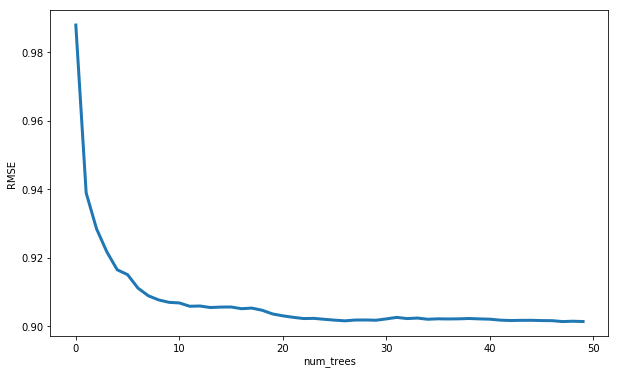

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('RMSE');

In [ ]:
pred=rf.predict(X_val)

In [ ]:
score=np.sqrt(mean_squared_error(y_val,pred))
score

0.9014451892493923

In [ ]:
y_train=label_cat_not_num_train["item_cnt_day"]
label_cat_not_num_train=label_cat_not_num_train.drop(["item_cnt_day"],axis=1)
label_cat_not_num_train=label_cat_not_num_train.drop(["date_block_num"],axis=1)
label_cat_not_num_test=label_cat_not_num_test.drop(["item_cnt_day"],axis=1)
label_cat_not_num_test=label_cat_not_num_test.drop(["date_block_num"],axis=1)

In [ ]:
rf = RandomForestRegressor(n_estimators=50, max_depth=16,max_features=0.4,min_samples_leaf=10,n_jobs=-1)
rf.fit(label_cat_not_num_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features=0.4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [ ]:
predictions=rf.predict(label_cat_not_num_test)

In [ ]:
sample_submissions["item_cnt_month"]=predictions
sample_submissions.head()

,ID,item_cnt_month
0,0,0.386226
1,1,0.404295
2,2,0.891662
3,3,0.377721
4,4,4.252783


In [ ]:
sample_submissions.to_csv("random_forest_lagged_features_6.csv",index=False)